In [6]:
import os

if not os.getcwd().endswith('mob2crime'):
    os.chdir('..')
os.getcwd()

'/mnt/d/1ResProj/mob2crime'

# default CRS is equal-area CRS, also good at buffering

## Claimed to be equal-area

https://gis.stackexchange.com/questions/234075/crs-for-calculating-areas-in-mexico?noredirect=1&lq=1

If you want to calculate areas in km2 you must use INEGI's lambert conformal conic projection. In QGis 2.14 you can find that EPSG 6362 (ITRF92) and 6372 (ITRF2008)have the specific parameters for this projection which are:

+proj=lcc +lat_1=17.5 +lat_2=29.5 +lat_0=12 +lon_0=-102 +x_0=2500000 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs




the CRS in INEGI national wide shapefile equals to EPSG 6372 and 6632

https://epsg.io/6362 is replaced by 6372 since 2010 December

In [37]:
import fiona
import geopandas as gp
import pandas as pd

In [33]:
inegi2018 = gp.read_file('data/mexico/inegi2018/01_aguascalientes/conjunto de datos/01a.shp')

In [34]:
mglu_2010 = gp.read_file('data/mexico/geography-socioeconomics/2010CensusGeography/national_macro/mglu2010v5_0/poligonos_urbanos.shp')

In [35]:
crs_string = fiona.crs.from_string('+proj=lcc +lat_1=17.5 +lat_2=29.5 +lat_0=12 +lon_0=-102 +x_0=2500000 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs')
p = crs_string.pop('towgs84')
print(inegi2018.crs==crs_string, mglu_2010.crs==crs_string)
crs_string['towgs84'] = p

True True


In [43]:
d = {
   ('crs', 'inegi2018'): (inegi2018.to_crs(crs_string).geometry == inegi2018.geometry).value_counts(),
   ('crs', 'mglu_2010'):(mglu_2010.to_crs(crs_string).geometry == mglu_2010.geometry).value_counts(),
    ('epsg6372', 'inegi2018'): (inegi2018.to_crs(epsg=6372).geometry == inegi2018.geometry).value_counts(),
    ('epsg6372', 'mglu_2010'): (mglu_2010.to_crs(epsg=6372).geometry == mglu_2010.geometry).value_counts(),
    ('epsg6362', 'inegi2018'): (inegi2018.to_crs(epsg=6362).geometry == inegi2018.geometry).value_counts(),
    ('epsg6362', 'mglu_2010'): (mglu_2010.to_crs(epsg=6362).geometry == mglu_2010.geometry).value_counts(),
    
}
pd.DataFrame(d)

crs            epsg6372            epsg6362          
     inegi2018 mglu_2010 inegi2018 mglu_2010 inegi2018 mglu_2010
True       436      4525       436      4525       436      4525

## buffer as intended distance (+/- 1 m)

In [53]:
loc_centr = mglu_2010.geometry.apply(lambda x: x.centroid)

In [58]:
loc_centr_4326 = loc_centr.to_crs(epsg=4326)

In [59]:
loc_centr_b_in_area = loc_centr.buffer(100).to_crs(epsg=4326)

In [95]:
compare = pd.DataFrame([loc_centr_4326, loc_centr_b_in_area_4326]).T
compare.columns=['center', 'buffered']
compare.head()

,center,buffered
0,POINT (-99.1490070147976 19.20063327910548),POLYGON ((-99.14805381249046 19.20061527180018...
1,POINT (-99.22768064068471 19.35453301042063),POLYGON ((-99.22672635035502 19.35451549673984...
2,POINT (-99.20534142914195 19.2198434221025),POLYGON ((-99.20438808505531 19.21982577010652...
3,POINT (-99.17499155122152 19.13421450432435),"POLYGON ((-99.17403880993442 19.1341966625142,..."
4,POINT (-99.09533524936744 19.25123597065827),POLYGON ((-99.09438170010226 19.25121762335915...


In [96]:
from src.utils.gis import haversine

In [98]:
dists  = []
for _, row in compare.iterrows():
    center = row.center
    circle = row.buffered
    for p in circle.boundary.coords:
        dist = haversine(center.coords[0][0], center.coords[0][1], p[0], p[1])
        dists.append(dist)


In [88]:
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3aead0ccc0>]],
      dtype=object)

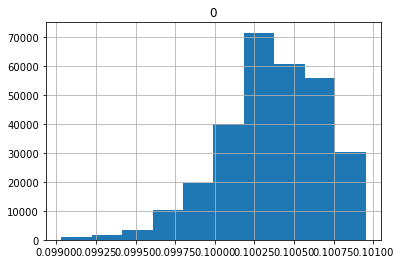

In [99]:
pd.DataFrame(dists).hist()